# A2: Bias in Data Assignment

### DATA 512

#### Emily Yamauchi

The goal of this assignment is to explore the concept of bias through data on Wikipedia articles - specifically, articles on political figures from a variety of countries. For this assignment, you will combine a dataset of Wikipedia articles with a dataset of country populations, and use a machine learning service called ORES to estimate the quality of each article.  

You are expected to perform an analysis of how the coverage of politicians on Wikipedia and the quality of articles about politicians varies between countries. Your analysis will consist of a series of tables that show:  

1. the countries with the greatest and least coverage of politicians on Wikipedia compared to their population.
2. the countries with the highest and lowest proportion of high quality articles about politicians.
3. a ranking of geographic regions by articles-per-person and proportion of high quality articles.  

You are also expected to write a short reflection on the project that focuses on how both your findings from this analysis and the process you went through to reach those findings helps you understand the causes and consequences of biased data in large, complex data science projects.


## Step 1: Getting the Article and Population Data

The first step is getting the data, which lives in several different places. The Wikipedia [politicians by country dataset](https://figshare.com/articles/Untitled_Item/5513449) can be found on Figshare. Read through the documentation for this repository, then download and unzip it to extract the data file, which is called `page_data.csv`.  

The population data is available in CSV format as [`WPDS_2020_data.csv`](https://docs.google.com/spreadsheets/d/1CFJO2zna2No5KqNm9rPK5PCACoXKzb-nycJFhV689Iw/edit?usp=sharing). This dataset is drawn from the [world population data sheet](https://www.prb.org/international/indicator/population/table/) published by the Population Reference Bureau.

In [1]:
from zipfile import ZipFile
import os

import pandas as pd
import numpy as np

## Step 0: download the two files above to data_raw directory

In [2]:
# Unzip politician file

os.chdir('data_raw')

with ZipFile('country.zip') as zipfiles:
    zipfiles.extractall()
    
os.chdir('..')

os.getcwd()

'C:\\Users\\admin\\Documents\\UW\\DATA512\\Assignments\\A2'

In [3]:
# load country politician data from unzipped folder

pols = pd.read_csv('data_raw/country/data/page_data.csv')

pols.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [4]:
# load population data

skiprows = range(4) # csv file includes headers
pops = pd.read_csv('data_raw/export.csv', skiprows=list(skiprows))

pops.head()

,FIPS,Name,Type,TimeFrame,Data
0,WORLD,WORLD,World,2019,7772.850
1,AFRICA,AFRICA,Sub-Region,2019,1337.918
2,NORTHERN AFRICA,NORTHERN AFRICA,Sub-Region,2019,244.344
3,DZ,Algeria,Country,2019,44.357
4,EG,Egypt,Country,2019,100.803


In [5]:
# Check if there's multiple TimeFrame

pops.TimeFrame.unique()

array([2019], dtype=int64)

In [6]:
#separately, find the 'running total' for sub-region to use later

# helper- return the index if sub region
is_sub = (pops.Type == 'Sub-Region') * pops.index

# get last index of sub-region- basically max(if(type==sub-region)) 
sub_ix = is_sub.expanding(1).apply(lambda x: max(x))

pops['subregion'] = pops.loc[sub_ix]['Name'].values

pops.head()

,FIPS,Name,Type,TimeFrame,Data,subregion
0,WORLD,WORLD,World,2019,7772.850,WORLD
1,AFRICA,AFRICA,Sub-Region,2019,1337.918,AFRICA
2,NORTHERN AFRICA,NORTHERN AFRICA,Sub-Region,2019,244.344,NORTHERN AFRICA
3,DZ,Algeria,Country,2019,44.357,NORTHERN AFRICA
4,EG,Egypt,Country,2019,100.803,NORTHERN AFRICA


## Step 2: Cleaning the Data

Both `page_data.csv` and `WPDS_2020_data.csv` contain some rows that you will need to filter out and/or ignore when you combine the datasets in the next step. In the case of `page_data.csv`, the dataset contains some page names that start with the string "`Template`:". These pages are not Wikipedia articles, and should not be included in your analysis.  

Similarly, `WPDS_2020_data.csv` contains some rows that provide cumulative regional population counts, rather than country-level counts. These rows are distinguished by having ALL CAPS values in the 'geography' field (e.g. `AFRICA`, `OCEANIA`). These rows won't match the country values in `page_data.csv`, but you will want to retain them (either in the original file, or a separate file) so that you can report coverage and quality by region in the analysis section.

In [7]:
# how many template files?

pols.loc[pols['page'].str.contains('Template:')].shape

(496, 3)

In [8]:
# drop the template pages

pols_keep = pols[~pols.page.str.contains('Template:')].reset_index(drop=True)

pols_keep.head()

,page,country,rev_id
0,Bir I of Kanem,Chad,355319463
1,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188
2,Yos Por,Cambodia,393822005
3,Julius Gregr,Czech Republic,395521877
4,Edvard Gregr,Czech Republic,395526568


In [9]:
# population types?

pops.Type.unique()

array(['World', 'Sub-Region', 'Country'], dtype=object)

In [10]:
# keep just ones that aren't ALL CAPS

pops_keep = pops.loc[pops.Name.str.isupper()==False]

# get a separate subregion df for just the 'country' names

country_name = pd.unique(pops_keep.Name)
df_subregion = pops_keep.loc[pops_keep.Name==country_name].copy().reset_index(drop=True)

# drop the subregion from the pops_keep dataframe

pops_keep = pops_keep.drop(columns=['subregion'])

pops_keep.head()

,FIPS,Name,Type,TimeFrame,Data
3,DZ,Algeria,Country,2019,44.357
4,EG,Egypt,Country,2019,100.803
5,LY,Libya,Country,2019,6.891
6,MA,Morocco,Country,2019,35.952
7,SD,Sudan,Country,2019,43.849


In [11]:
df_subregion.head()

,FIPS,Name,Type,TimeFrame,Data,subregion
0,DZ,Algeria,Country,2019,44.357,NORTHERN AFRICA
1,EG,Egypt,Country,2019,100.803,NORTHERN AFRICA
2,LY,Libya,Country,2019,6.891,NORTHERN AFRICA
3,MA,Morocco,Country,2019,35.952,NORTHERN AFRICA
4,SD,Sudan,Country,2019,43.849,NORTHERN AFRICA


In [12]:
# just checking

pops_keep.loc[pops_keep.Type!='Country']

,FIPS,Name,Type,TimeFrame,Data
168,Channel Islands,Channel Islands,Sub-Region,2019,0.172


In [13]:
# write clean files to csv

pols_keep.to_csv('data_clean/politicians.csv', index=False)

pops_keep.to_csv('data_clean/populations.csv', index=False)

df_subregion.to_csv('data_clean/subregions.csv', index=False)

## Step 3: Getting Article Quality Predictions

Now you need to get the predicted quality scores for each article in the Wikipedia dataset. We're using a machine learning system called ORES. This was originally an acronym for "Objective Revision Evaluation Service" but was simply renamed “ORES”. ORES is a machine learning tool that can provide estimates of Wikipedia article quality. The article quality estimates are, from best to worst:  

1. FA - Featured article
2. GA - Good article
3. B - B-class article
4. C - C-class article
5. Start - Start-class article
6. Stub - Stub-class article  

These were learned based on articles in Wikipedia that were peer-reviewed using the [Wikipedia content assessment](https://en.wikipedia.org/wiki/Wikipedia:Content_assessment) procedures.These quality classes are a sub-set of quality assessment categories developed by Wikipedia editors. For this assignment, you only need to know that these categories exist, and that ORES will assign one of these 6 categories to any `rev_id` you send it.  

In order to get article predictions for each article in the Wikipedia dataset, you will first need to read `page_data.csv` into Python (or R), and then read through the dataset line by line, using the value of the `rev_id` column to make an API query.

#### Option 1:   

Install and run the ORES client (Python only)  
*Didn't use*

#### Option 2:

Use the REST API endpoint (Python or R)  

The ORES REST API is configured fairly similarly to the pageviews API we used for Assignment 1. You should review the ORES REST [documentation](https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model). It expects a revision ID, which is the third column in the Wikipedia dataset, and a model, which is "`articlequality`".  

Whether you query the API or use the client, you will notice that ORES returns a `prediction` value that contains the name of one category, as well as `probability` values for each of the 6 quality categories. For this assignment, you only need to capture and use the value for `prediction`.  

Note: It's possible that you will be unable to get a score for a particular article. If that happens, make sure to maintain a log of articles for which you were not able to retrieve an ORES score. This log can be saved as a separate file, or (if it's only a few articles), simply printed and logged within the notebook. The choice is up to you.


In [14]:
import requests
import json

In [15]:
# load data

page_data = pd.read_csv('data_clean/politicians.csv')    

print('page_data.shape: ', page_data.shape)

page_data.shape:  (46701, 3)


In [16]:
# get the rev ids

rev_ids = page_data.rev_id

In [17]:
# endpoint and headers

url = 'https://ores.wikimedia.org/v3/scores/enwiki?models=articlequality&revids={rev_id}'

headers = {
    'User-Agent': 'https://github.com/emi90',
    'From': 'eyamauch@uw.edu'
}

In [18]:
def api_call(url, rev_id):
    """
    Function to call API for given revision id
    url: endpoint url
    rev_id: revision id
    """
    
    call = requests.get(url.format(rev_id=rev_id), headers=headers)
    response = call.json()
    
    return response

In [19]:
# test

api_call(url, rev_ids[0])

{'enwiki': {'models': {'articlequality': {'version': '0.8.2'}},
  'scores': {'355319463': {'articlequality': {'score': {'prediction': 'Stub',
      'probability': {'B': 0.005643168767502225,
       'C': 0.005641424870624224,
       'FA': 0.0010757577110297029,
       'GA': 0.001543343686495854,
       'Start': 0.010537503531047517,
       'Stub': 0.9755588014333005}}}}}}}

In [20]:
# function to get batch number array

def get_batches(n):
    
    """
    Function to get the batch number array
    n: number of api calls within a batch
    Returns: batch array and number of batches
    """
    
    # number of batches to create
    num_batch = np.ceil(page_data.shape[0]/n)
    
    # mod for last batch count
    mod = np.mod(page_data.shape[0], n)
    
    # get batch number array
    batch_no = np.repeat(np.arange(0, num_batch-1), n)
    
    # append final uneven array
    batch_no = np.append(batch_no, np.repeat(num_batch-1, mod))
    
    return batch_no, int(num_batch)

In [21]:
# check

print('batch_no.shape: ', get_batches(50)[0].shape)
print('page_data.shape: ', page_data.shape)

batch_no.shape:  (46701,)
page_data.shape:  (46701, 3)


In [22]:
# test - first 50 revids

batch_arr = get_batches(50)[0]
rev_ids[batch_arr==0][0:5]

0    355319463
1    393276188
2    393822005
3    395521877
4    395526568
Name: rev_id, dtype: int64

In [23]:
# function to call api for each batch count

def api_call_batch(url, n, batch):
    
    """
    Function to call api for given batch, given n calls in each batch
    url: endpoint url
    n: number of api calls in a batch
    batch: ith batch call
    """
    
    batch_arr = get_batches(n)[0] # batch numbers
    batch_ids = rev_ids[batch_arr==batch] # just the rev_id for those that match the ith batch
    rev_id = "|".join(str(x) for x in batch_ids) # join to single string
    
    call = requests.get(url.format(rev_id=rev_id))
    response = call.json()
    
    return response

In [24]:
# test - 934 doesn't work

api_call_batch(url, 50, 934)

{'enwiki': {'models': {'articlequality': {'version': '0.8.2'}},
  'scores': {'807484325': {'articlequality': {'error': {'message': 'RevisionNotFound: Could not find revision ({revision}:807484325)',
      'type': 'RevisionNotFound'}}}}}}

In [25]:
# test - this works

api_call_batch(url, 50, 900)

{'enwiki': {'models': {'articlequality': {'version': '0.8.2'}},
  'scores': {'806627526': {'articlequality': {'score': {'prediction': 'Start',
      'probability': {'B': 0.03125367008982778,
       'C': 0.06875626899559285,
       'FA': 0.004652422362104155,
       'GA': 0.008825409922756884,
       'Start': 0.6040291746449679,
       'Stub': 0.2824830539847503}}}},
   '806629826': {'articlequality': {'score': {'prediction': 'B',
      'probability': {'B': 0.40735526752663526,
       'C': 0.1754360183328461,
       'FA': 0.1149725572953111,
       'GA': 0.28623880355422676,
       'Start': 0.011431989953071703,
       'Stub': 0.004565363337909157}}}},
   '806631152': {'articlequality': {'score': {'prediction': 'Stub',
      'probability': {'B': 0.004371233009357412,
       'C': 0.006140726968139728,
       'FA': 0.0008617864211266214,
       'GA': 0.00192563406313747,
       'Start': 0.00978644881476089,
       'Stub': 0.9769141707234779}}}},
   '806631359': {'articlequality': {'score'

In [26]:
def get_json(url, n):
    """
    Function to get json of all the api calls 
    url: endpoint url
    n: number of calls per batch (50 is max)
    """
    
    all_data = {}
    err_batch = []
    
    total_batches = get_batches(n)[1] # number of batches to go through
    print('total batches: ', total_batches)
    
    for i in range(total_batches):
        if np.mod(i, 100) == 0:
            print('Currently processing batch: ', i)
        resp = api_call_batch(url, n, i)
        
        try:
            scores = resp['enwiki']['scores']
            all_data.update(scores)
        except:
            err_batch.append(i)
    
    return all_data, err_batch

In [27]:
# this will take a while (approx 5 min)

import time

start = time.time()

res = get_json(url, 50)

end = time.time()

print('time took: ', end-start)

total batches:  935
Currently processing batch:  0
Currently processing batch:  100
Currently processing batch:  200
Currently processing batch:  300
Currently processing batch:  400
Currently processing batch:  500
Currently processing batch:  600
Currently processing batch:  700
Currently processing batch:  800
Currently processing batch:  900
time took:  303.2493782043457


In [28]:
def get_prediction(result):
    """
    Function to get the 'prediction' from ORES api call
    Returns df of revid and prediction (can be nan)
    """
    
    scores = result[0] #json file
    
    df = pd.DataFrame(scores).T
    df_norm = pd.json_normalize(df['articlequality'])
    df_norm['rev_id'] = res[0].keys()
    df_norm['rev_id'] = df_norm['rev_id'].astype(int) #keys are str
    
    df_res = df_norm[['score.prediction', 'rev_id']]
    
    return df_res

In [29]:
df = get_prediction(res)

df.head()

,score.prediction,rev_id
0,Stub,355319463
1,Stub,393276188
2,Stub,393822005
3,Stub,395521877
4,Stub,395526568


In [30]:
# logging NaN scores

no_scores = df.loc[df['score.prediction'].isna()].reset_index(drop=True)
no_scores.to_csv('data_clean/no_scores.csv')

no_scores.head()

,score.prediction,rev_id
0,NaN,516633096
1,NaN,550682925
2,NaN,627547024
3,NaN,636911471
4,NaN,669987106


In [31]:
# drop the NaN scores to prevent confusion btw no scores vs no pages
# add just the score.prediction to page_data

df_score = df.loc[df['score.prediction'].isna()==False].reset_index(drop=True)
wiki_score = page_data.merge(df_score)

wiki_score.head()

,page,country,rev_id,score.prediction
0,Bir I of Kanem,Chad,355319463,Stub
1,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188,Stub
2,Yos Por,Cambodia,393822005,Stub
3,Julius Gregr,Czech Republic,395521877,Stub
4,Edvard Gregr,Czech Republic,395526568,Stub


In [32]:
# check

print('df.shape: ', df.shape)
print('wiki_score.shape: ', wiki_score.shape)
print('no_scores.shape: ', no_scores.shape)

df.shape:  (46701, 2)
wiki_score.shape:  (46425, 4)
no_scores.shape:  (276, 2)


## Step 3: Combining the Datasets

Some processing of the data will be necessary! In particular, you'll need to - after retrieving and including the ORES data for each article - merge the wikipedia data and population data together. Both have fields containing country names for just that purpose. After merging the data, you'll invariably run into entries which cannot be merged. Either the population dataset does not have an entry for the equivalent Wikipedia country, or vise versa.  

Please remove any rows that do not have matching data, and output them to a CSV file called:  
>`wp_wpds_countries-no_match.csv`  

Consolidate the remaining data into a single CSV file called:  
>`wp_wpds_politicians_by_country.csv`  

The schema for that file should look something like this:  

| Column      |
| ----------- |
| country |
| article_name |
| revision_id |
| article_quality_est. |
| population |

Note: `revision_id` here is the same thing as `rev_id`, which you used to get scores from ORES.

In [33]:
# Load population data

pop = pd.read_csv('data_clean/populations.csv')

pop.head()

,FIPS,Name,Type,TimeFrame,Data
0,DZ,Algeria,Country,2019,44.357
1,EG,Egypt,Country,2019,100.803
2,LY,Libya,Country,2019,6.891
3,MA,Morocco,Country,2019,35.952
4,SD,Sudan,Country,2019,43.849


In [34]:
# Merge population with wiki scores data

data_merge = pd.merge(pop, wiki_score, left_on='Name', right_on='country', how='outer')

data_merge = data_merge.rename(columns = {
    'Name' : 'population_country',
    'page' : 'article_name',
    'rev_id' : 'revision_id',
    'score.prediction' : 'article_quality_est',
    'Data' : 'population'
})

In [35]:
# match scheuma

keep_cols = ['population_country',
             'country',
             'article_name',
             'revision_id',
             'article_quality_est',
             'population']

data_all = data_merge[keep_cols]

data_all.head()

,population_country,country,article_name,revision_id,article_quality_est,population
0,Algeria,Algeria,Ali Fawzi Rebaine,686269631.0,Stub,44.357
1,Algeria,Algeria,Ahmed Attaf,705910185.0,Stub,44.357
2,Algeria,Algeria,Ahmed Djoghlaf,707427823.0,Stub,44.357
3,Algeria,Algeria,Hammi Larouissi,708060571.0,Stub,44.357
4,Algeria,Algeria,Salah Goudjil,708980561.0,Stub,44.357


In [36]:
# outer join and show the nans

data_all.tail()

,population_country,country,article_name,revision_id,article_quality_est,population
46447,NaN,Somaliland,Dahir Riyale Kahin,798692052.0,Start,NaN
46448,NaN,Somaliland,Adan Ahmed Elmi,804143605.0,Stub,NaN
46449,NaN,Somaliland,Muhammad Haji Ibrahim Egal,805840190.0,C,NaN
46450,NaN,Rojava,Hediya Yousef,805873719.0,C,NaN
46451,NaN,Rojava,Mansur Selum,805873803.0,Stub,NaN


In [37]:
# what matched?

data_match = data_all.dropna().drop(columns=['population_country']).reset_index(drop=True)

data_match.head()

,country,article_name,revision_id,article_quality_est,population
0,Algeria,Ali Fawzi Rebaine,686269631.0,Stub,44.357
1,Algeria,Ahmed Attaf,705910185.0,Stub,44.357
2,Algeria,Ahmed Djoghlaf,707427823.0,Stub,44.357
3,Algeria,Hammi Larouissi,708060571.0,Stub,44.357
4,Algeria,Salah Goudjil,708980561.0,Stub,44.357


In [38]:
# what didn't match?

data_no_match = data_all.loc[~data_all.revision_id.isin(data_match.revision_id)].copy()

data_no_match.country.fillna(data_no_match.population_country, inplace=True)

data_no_match = data_no_match.drop(columns=['population_country'])

data_no_match.head()

,country,article_name,revision_id,article_quality_est,population
899,Western Sahara,NaN,NaN,NaN,0.597
1122,Cote d'Ivoire,NaN,NaN,NaN,26.175
4118,Mayotte,NaN,NaN,NaN,0.284
4177,Reunion,NaN,NaN,NaN,0.861
6061,"Congo, Dem. Rep.",NaN,NaN,NaN,89.568


In [39]:
print('data_match.shape: ', data_match.shape)
print('data_no_match.shape: ', data_no_match.shape)
print('total: ', data_no_match.shape[0] + data_match.shape[0])

data_match.shape:  (44568, 5)
data_no_match.shape:  (1884, 5)
total:  46452


In [40]:
# save .csv

data_no_match.to_csv('data_clean/wp_wpds_countries_no_match.csv', index=False)
data_match.to_csv('data_clean/wp_wpds_politicians_by_country.csv', index=False)

## Step 4: Analysis

Your analysis will consist of calculating the proportion (as a percentage) of articles-per-population and high-quality articles for each country AND for each geographic region. By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.  

Examples:  

- if a country has a population of 10,000 people, and you found 10 FA or GA class articles about politicians from that country, then the percentage of articles-per-population would be .1%.
- if a country has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%.


In [41]:
# load data

score_df = pd.read_csv('data_clean/wp_wpds_politicians_by_country.csv')

sub_df = pd.read_csv('data_clean/subregions.csv')

In [42]:
# populate subregion columns

score_df['subregion'] = score_df.country.map(dict(sub_df[['Name', 'subregion']].values))

score_df.head()

,country,article_name,revision_id,article_quality_est,population,subregion
0,Algeria,Ali Fawzi Rebaine,686269631.0,Stub,44.357,NORTHERN AFRICA
1,Algeria,Ahmed Attaf,705910185.0,Stub,44.357,NORTHERN AFRICA
2,Algeria,Ahmed Djoghlaf,707427823.0,Stub,44.357,NORTHERN AFRICA
3,Algeria,Hammi Larouissi,708060571.0,Stub,44.357,NORTHERN AFRICA
4,Algeria,Salah Goudjil,708980561.0,Stub,44.357,NORTHERN AFRICA


In [43]:
good_articles = ['FA', 'GA']

score_df['is_good'] = score_df.article_quality_est.isin(good_articles)

In [44]:
# country

country_total = score_df.groupby('country')['revision_id'].count()

country_groupby = score_df.groupby(['country','is_good']).apply(lambda x: x.count())['revision_id']

good_country = (country_groupby/country_total).reset_index().rename(columns={'revision_id':'%article'})

good_country.head()

,country,is_good,%article
0,Afghanistan,False,0.959248
1,Afghanistan,True,0.040752
2,Albania,False,0.993421
3,Albania,True,0.006579
4,Algeria,False,0.982759


In [45]:
# check 

sum_total = good_country.groupby('country').sum().reset_index()

sum_total.loc[sum_total['%article'] != 1]

,country,is_good,%article


In [46]:
# subregion

subregion_total = score_df.groupby('subregion')['revision_id'].count()

subregion_groupby = score_df.groupby(['subregion', 'is_good']).apply(lambda x: x.count())['revision_id']

good_subregion = (subregion_groupby/subregion_total).reset_index().rename(columns={'revision_id':'%article'})

good_subregion.head()

,subregion,is_good,%article
0,CARIBBEAN,False,0.981295
1,CARIBBEAN,True,0.018705
2,CENTRAL AMERICA,False,0.985094
3,CENTRAL AMERICA,True,0.014906
4,CENTRAL ASIA,False,0.971429


In [47]:
# check

sum_total_sub = good_subregion.groupby('subregion').sum().reset_index()

sum_total_sub.loc[sum_total_sub['%article'] != 1]

,subregion,is_good,%article


# Step 5: Results

Your results from this analysis will be published in the form of data tables. You are being asked to produce six total tables, that show:  

1. Top 10 countries by coverage: 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
2. Bottom 10 countries by coverage: 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
3. Top 10 countries by relative quality: 10 highest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality
4. Bottom 10 countries by relative quality: 10 lowest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality
5. Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the total count of politician articles from countries in each region as a proportion of total regional population
6. Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the relative proportion of politician articles from countries in each region that are of GA and FA-quality  


Embed these tables in your Jupyter notebook. You do not need to graph or otherwise visualize the data for this assignment, although you are welcome to do so in addition to generating the data tables described above, if you wish.

##### 1. Top 10 countries by coverage: 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [48]:
# get coverage of politician as proportion of population

# number of articles
n_articles = country_total.reset_index().rename(columns={'revision_id':'num_articles'})

# get just the population
pops_country = score_df[['country', 'population']].drop_duplicates().reset_index(drop=True)
country_coverage = pops_country.merge(n_articles)

# proportion of population
country_coverage['article_prop'] = country_coverage.num_articles/country_coverage.population

# get top 10
country_coverage.sort_values('article_prop', ascending=False)[0:10]

,country,population,num_articles,article_prop
181,Tuvalu,0.010,54,5400.000000
176,Nauru,0.011,52,4727.272727
167,San Marino,0.034,81,2382.352941
145,Monaco,0.038,40,1052.631579
143,Liechtenstein,0.039,28,717.948718
175,Marshall Islands,0.057,37,649.122807
180,Tonga,0.099,63,636.363636
132,Iceland,0.368,201,546.195652
158,Andorra,0.082,34,414.634146
172,Federated States of Micronesia,0.106,36,339.622642


##### 2. Bottom 10 countries by coverage: 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [49]:
# get bottom 10

country_coverage.sort_values('article_prop')[0:10]

,country,population,num_articles,article_prop
108,India,1400.100,968,0.691379
115,Indonesia,271.739,209,0.769120
123,China,1402.385,1129,0.805057
104,Uzbekistan,34.174,28,0.819336
25,Ethiopia,114.916,101,0.878903
37,Zambia,18.384,25,1.359878
125,"Korea, North",25.779,36,1.396486
121,Thailand,66.534,112,1.683350
30,Mozambique,31.166,58,1.861002
106,Bangladesh,169.809,317,1.866803


##### 3. Top 10 countries by relative quality: 10 highest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [50]:
# get the good quality scores

good_country_coverage = good_country.merge(pops_country)

# proportion of good quality coverage by country population
good_country_coverage['quality_prop'] = good_country_coverage['%article']/good_country_coverage.population

# top 10
good_country_coverage.loc[good_country_coverage.is_good==True].sort_values('%article',ascending=False)[0:10]

,country,is_good,%article,population,quality_prop
148,"Korea, North",True,0.222222,25.779,0.008620
250,Saudi Arabia,True,0.128205,35.041,0.003659
242,Romania,True,0.122449,19.241,0.006364
55,Central African Republic,True,0.121212,4.830,0.025096
317,Uzbekistan,True,0.107143,34.174,0.003135
189,Mauritania,True,0.104167,4.650,0.022401
111,Guatemala,True,0.084337,18.066,0.004668
78,Dominica,True,0.083333,0.072,1.157407
284,Syria,True,0.078125,19.398,0.004027
30,Benin,True,0.076923,12.209,0.006301


##### 4. Bottom 10 countries by relative quality: 10 lowest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality

In [51]:
# bottom 10

good_country_coverage.loc[good_country_coverage.is_good==True].sort_values('%article',ascending=True)[0:10]

,country,is_good,%article,population,quality_prop
27,Belgium,True,0.001927,11.515,0.000167
290,Tanzania,True,0.002475,59.734,0.000041
282,Switzerland,True,0.002488,8.634,0.000288
208,Nepal,True,0.002809,29.996,0.000094
232,Peru,True,0.002857,32.824,0.000087
218,Nigeria,True,0.002959,206.140,0.000014
238,Portugal,True,0.003145,10.255,0.000307
63,Colombia,True,0.003509,49.444,0.000071
170,Lithuania,True,0.004098,2.794,0.001467
201,Morocco,True,0.004854,35.952,0.000135


##### 5. Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the total count of politician articles from countries in each region as a proportion of total regional population

In [52]:
# get article coverage for subregion

sub_coverage = country_coverage.merge(
    sub_df[['subregion','Name']], left_on='country', right_on='Name').drop(columns=['Name'])

# group by subregion
sub_coverage = sub_coverage.groupby('subregion').sum()[['population','num_articles']].reset_index()

# get proportion of articles by subregion population
sub_coverage['article_prop'] = sub_coverage.num_articles/sub_coverage.population

# sort by proportion of articles descending
sub_coverage.sort_values('article_prop', ascending=False)

,subregion,population,num_articles,article_prop
10,OCEANIA,42.031,3126,74.373677
3,Channel Islands,105.680,3763,35.607494
15,SOUTHERN EUROPE,151.136,3710,24.547427
18,WESTERN EUROPE,195.479,4560,23.327314
0,CARIBBEAN,39.056,695,17.794961
6,EASTERN EUROPE,281.186,3732,13.272354
14,SOUTHERN AFRICA,66.628,634,9.515519
1,CENTRAL AMERICA,162.267,1543,9.509019
17,WESTERN ASIA,272.499,2563,9.405539
7,MIDDLE AFRICA,90.189,665,7.373405


##### 6. Geographic regions by coverage: Ranking of geographic regions (in descending order) in terms of the relative proportion of politician articles from countries in each region that are of GA and FA-quality

In [53]:
# get good article coverage for subregion

good_subregion_coverage = good_subregion.merge(sub_coverage)

# sort by good article proportion descending
good_subregion_coverage.loc[good_subregion_coverage.is_good==True].sort_values('%article', ascending=False)

,subregion,is_good,%article,population,num_articles,article_prop
19,NORTHERN AMERICA,True,0.054708,368.068,1901,5.164807
27,SOUTHEAST ASIA,True,0.036139,660.056,2020,3.060346
35,WESTERN ASIA,True,0.034725,272.499,2563,9.405539
13,EASTERN EUROPE,True,0.031618,281.186,3732,13.272354
9,EAST ASIA,True,0.030732,1632.883,2473,1.514499
5,CENTRAL ASIA,True,0.028571,74.960,245,3.268410
7,Channel Islands,True,0.027106,105.680,3763,35.607494
15,MIDDLE AFRICA,True,0.024060,90.189,665,7.373405
17,NORTHERN AFRICA,True,0.021135,243.748,899,3.688235
21,OCEANIA,True,0.020154,42.031,3126,74.373677


## Writeup: Reflections and Implications

Write a few paragraphs, either in the README or at the end of the notebook, reflecting on what you have learned, what you found, what (if anything) surprised you about your findings, and/or what theories you have about why any biases might exist (if you find they exist). You can also include any questions this assignment raised for you about bias, Wikipedia, or machine learning.  

In addition to any reflections you want to share about the process of the assignment, please respond (briefly) to **at least three** of the questions below:  

1. What biases did you expect to find in the data (before you started working with it), and why?
2. What (potential) sources of bias did you discover in the course of your data processing and analysis?
3. What might your results suggest about (English) Wikipedia as a data source?
4. What might your results suggest about the internet and global society in general?
5. Can you think of a realistic data science research situation where using these data (to train a model, perform a hypothesis-driven research, or make business decisions) might create biased or misleading results, due to the inherent gaps and limitations of the data?
6. Can you think of a realistic data science research situation where using these data (to train a model, perform a hypothesis-driven research, or make business decisions) might still be appropriate and useful, despite its inherent limitations and biases?
7. How might a researcher supplement or transform this dataset to potentially correct for the limitations/biases you observed?  

This section doesn't need to be particularly long or thorough, but we'll expect you to write at least a couple paragraphs.

###### 1. What biases did you expect to find in the data (before you started working with it), and why?  

Based on the discussion in class, I expected to find more articles for English-speaking countries as we were looking at the English version of Wikipedia. I also assumed that there would be a larger share of 'good quality' articles for US politicians, also based on our discussion - John McCain's highest office held was a presidential candidate that lost the election, but his article was `FA` rank while the actual head-of-state president of France was a lower grade.

##### 2. What (potential) sources of bias did you discover in the course of your data processing and analysis?


Without doing a formal testing it is impossible to say whether there are significant relationships or not, but there may be several factors impacting the total volume of articles.

*Language?*  
More articles in countries that are English speaking: 4/10 (including India)  

*Geopolitical/'Western World'?*  
More articles in 'Western World' countries - 6/10 including Russia  

*Population?*  
More articles in countries with large population - 5/10 in top 10 countries.  

Countries without larger population with larger volume of articles are English-speaking (Australia: 53rd) or have long Eurocentric recorded history (France: 21st, Spain, 29th).  

Interestingly, Nigeria is both population-ranking (7th) and English speaking (officially), but its article count ranks 166th.

In [54]:
# Top 10 countries with article volume

country_coverage.sort_values('num_articles', ascending=False)[0:10]

,country,population,num_articles,article_prop
141,France,64.940,1672,25.746843
171,Australia,25.754,1559,60.534286
123,China,1402.385,1129,0.805057
56,Mexico,127.792,1075,8.412107
52,United States,329.878,1062,3.219372
112,Pakistan,220.940,1019,4.612112
108,India,1400.100,968,0.691379
154,Russia,146.733,874,5.956397
170,Spain,47.635,871,18.284875
138,United Kingdom,67.160,855,12.730792


In [55]:
# Show population rank

country_coverage['pop_rank'] = country_coverage.population.rank(ascending=False)

country_coverage.sort_values('num_articles', ascending=False)[0:10]

,country,population,num_articles,article_prop,pop_rank
141,France,64.940,1672,25.746843,21.0
171,Australia,25.754,1559,60.534286,53.0
123,China,1402.385,1129,0.805057,1.0
56,Mexico,127.792,1075,8.412107,10.0
52,United States,329.878,1062,3.219372,3.0
112,Pakistan,220.940,1019,4.612112,5.0
108,India,1400.100,968,0.691379,2.0
154,Russia,146.733,874,5.956397,9.0
170,Spain,47.635,871,18.284875,29.0
138,United Kingdom,67.160,855,12.730792,19.0


In [56]:
# Top 10 countries by population

country_coverage.loc[country_coverage.pop_rank <= 10]

,country,population,num_articles,article_prop,pop_rank
17,Nigeria,206.140,676,3.279325,7.0
52,United States,329.878,1062,3.219372,3.0
56,Mexico,127.792,1075,8.412107,10.0
73,Brazil,211.812,545,2.573036,6.0
106,Bangladesh,169.809,317,1.866803,8.0
108,India,1400.100,968,0.691379,2.0
112,Pakistan,220.940,1019,4.612112,5.0
115,Indonesia,271.739,209,0.769120,4.0
123,China,1402.385,1129,0.805057,1.0
154,Russia,146.733,874,5.956397,9.0


In [57]:
# Nigeria? Both large population and English speaking

country_coverage['num_articles'].rank()[country_coverage.country=='Nigeria']

17    166.0
Name: num_articles, dtype: float64

##### 3. What might your results suggest about (English) Wikipedia as a data source?

As previously discussed, it seems that English Wikipedia has more articles for politicians in a. English speaking countries, b. countries considered part of the 'western world', and countries with large populations.  
It would be interesting to see how the results differ for other languages, and how the results differ for languages that are widely used as official languages in many countries (English, Spanish, etc.) or concentrated to specific countries (Chinese, Japanese, etc.)  
However, as the above tables suggest, it seems that language is not the only factor influencing the volume of articles, as Nigeria for example met 2 of the 3 factors suggested above but ranked very low on the article volume score. 

##### Other thoughts  

*Population*  
The analysis in the previous section controlled the article volume and quality by country population. While this may be a fair normalizing step, it seems to favor countries with small populations and penalize countries with larger populations. The highest ranking countries are all countries with very small populations, while the bottom ranked countries are similarly countries with larger populations.  

*Article quantity & quality*  
As discussed in class, the majority of the articles are of 'bad' quality. However, it seems that the proportion of good quality articles is not linear- we saw that the article quantity is larger for English-speaking western countries, but none of the good-quality articles fall into those categories. This makes some intuitive sense- there may be a large magnitude of 'stub' articles on US politicians for example, but that a person of equivalent significance in society from North Korea may be entirely unknown, and politicians who are featured in any type of article could be someone known well enough to merit a longer article, thereby increasing the proportion of 'good' quality articles of that country.

<AxesSubplot:xlabel='article_quality_est'>

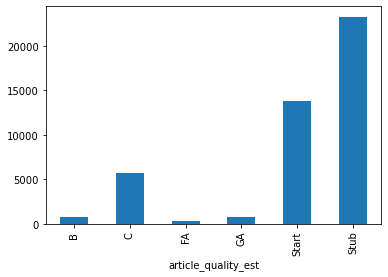

In [58]:
score_df.groupby('article_quality_est').count()['country'].plot(kind='bar')

<AxesSubplot:xlabel='is_good'>

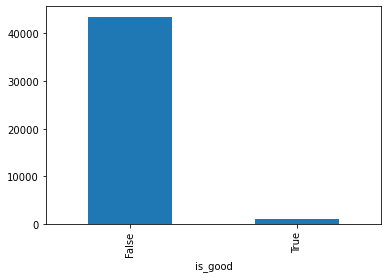

In [59]:
score_df.groupby('is_good').count()['country'].plot(kind='bar')